# Agent-Based Modeling of Collective Emotions: Implementing the Cyberemotions Framework

This notebook contains an implementation of the _Cyberemotions_ agent-based modeling framework in Python (version 3.7) that abstracts the emergence of collective emotions and the spread of emotional information in social media, following the formalization of [Garcia et al. (2016)](http://dx.doi.org/10.1098/rsos.160059).

## Model parameters

The standard model parameters are hardcoded, unless otherwise specified, as follows:

| Parameter | Short | Value | Constant
|---|---|---|---|
| Valence baseline | *b* | 0.056 | BASE_V |
| Arousal baseline | *d* | -0.442 | BASE_A |
| Valence decay | *&gamma;<sub>v</sub>* | 0.367 | DECAY_V |
| Arousal decay | *&gamma;<sub>a</sub>* | 0.414 | DECAY_A |
| Amplitudes | *A<sub>v</sub>* | 0.3 | AMP_V |
|| *A<sub>a</sub>* | 0.3 | AMP_A |
| Arousal threshold | *&tau;* | 0 | THRESH_A |
| Down-regulation factor | *k<sub>v</sub>* | 0.38 | FACTOR_V |
|| *k<sub>a</sub>* | 0.45 | FACTOR_A |
| Satiation factor | *c* | 1.0 | SAT_C |
| Valence coefficients | *b<sub>0</sub>* | 0.14 | COEFF_B0 |
|| *b<sub>1</sub>* | 0 | COEFF_B1 |
|| *b<sub>2</sub>* | 0.057 | COEFF_B2 |
|| *b<sub>3</sub>* | -0.047 | COEFF_B3 |
| Arousal coefficients | d<sub>0</sub> | 0.178 | COEFF_D0 |
|| *d<sub>1</sub>* | 0.14469 | COEFF_D1 |
|| *d<sub>2</sub>* | 0 | COEFF_D2 |
|| *d<sub>3</sub>* | 0 | COEFF_D3 |
| Field charge | *h* | 0 | CHARGE_H |
| Field decay | *&gamma;<sub>h</sub>* | 0.7 | DECAY_H |
| Field impact | *s* | 0.1 | IMPACT_H |

Satiation factor _c_ and field impact _s_ can be set using optional script arguments or as input to the `run()` function.

## Model design

The following section documents the code of the implemented model. **Settings** define standard number of model runs, agents, and time steps. **Parameters** set the constant values the model is run with. **Entities** describes the agent and the communication field as entities of their respective class, including the methods they go through: perception, expression, satiaion, relaxation (agents); and communication (field). **Schedule** the order of which the classes are called and their methods are executed. **Running the model** defines a model class that incorporates entities and schedule, in order to run the model at the given settings and parameters. **Storing the data** saves the output data in the feather format

In [1]:
import sys
import time
import pandas as pd
import numpy as np

### Settings

In [2]:
no_runs = 1 # Running the model once by default
no_agents = 150 # Arbitrary value
no_steps = 150 # Test runs rarely showed a model running for more than 100
               # time steps, and hence this should be an appropriate
               # maximum that does not cause premature abortion of a run

if __name__ == "__main__" and '__file__' in globals():
# Checking if there are arguments given and adjusting the settings accordingly:
    if len(sys.argv) > 2:
        no_runs = int(sys.argv[1])
        no_agents = int(sys.argv[2])
        no_steps = 150

MODEL_RUNS = no_runs # Number of times the model is run
AGENTS = no_agents # Number of agents at the start of the simulation
TIME = no_steps # Maximum number of time steps before the simulation ends

### Parameters

In [3]:
BASE_V = 0.056 # Valence baseline ... b
BASE_A = -0.442 # Arousal baseline ... d

THRESH_A = 0.0 # Arousal threshold ... tau

DECAY_V = 0.367 # Valence decay ... gamma_v
DECAY_A = 0.414 # Arousal decay ... gamma_a
AMP_V = 0.3 # Valence amplitude of stochastic shocks ... A_v
AMP_A = 0.3 # Arousal amplitude of stochastic shocks ... A_a
FACTOR_V = 0.38 # Valence down-regulation factor ... k_v
FACTOR_A = 0.45 # Arousal down-regulation factor ... k_a

COEFF_B0 = 0.14 # Valence coefficient ... b_0
COEFF_B1 = 0 # Valence coefficient ... b_1
COEFF_B2 = 0.057 # Valence coefficient ... b_2
COEFF_B3 = -0.047 # Valence coefficient ... b_3

COEFF_D0 = 0.178 # Arousal coefficient ... d_0
COEFF_D1 = 0.14469  # Arousal coefficient ... d_1
COEFF_D2 = 0  # Arousal coefficient ... d_2
COEFF_D3 = 0  # Arousal coefficient ... d_3

CHARGE_H = 0 # Initial charge of the field ... h
DECAY_H = 0.7 # Field decay ... gamma_h

impct = 0.1 
# Note: Test runs showed with standard value s = 0.1 the model only behaves as
# expected with 150 agents. Scaling is needed and can be set using arguments.
sttn = 1.0

if __name__ == "__main__" and '__file__' in globals():
# Checking if there are arguments given and adjusting the parameters
# accordingly:
    if len(sys.argv) > 3:
        impct = float(sys.argv[3]) / AGENTS
        sttn = float(sys.argv[4])

IMPACT_H = impct # Impact of agent expressions on the field ... s
SAT_C = sttn # Saturation factor ... c

### Entities

In [4]:
class Agent:
    '''Class describing one agent instance and its state variables.'''
    def __init__(self):
        self.bsln_v = np.random.normal(BASE_V, 0.1) # Valence baseline
        self.bsln_a = np.random.normal(BASE_A, 0.1) # Arousal baseline
        # Note: Spread of the normal distrution should not cause valence or
        # arousal baselines to lie above 1 or below -1
        self.vlnc = self.bsln_v # Setting initial valence to baseline value
        self.arsl = self.bsln_a # Setting initial arousal to baseline value
        self.thrshld = THRESH_A # Arousal threshold
        self.hstry_v = [] # History of valence values at each time step
        self.hstry_a = [] # History of arousal values at each time step

    def perception(self, field):
        '''Method changing the agent state variables given their perception of
        the field, using its state variable as input and adding stochasticity
        to global change coefficients'''
        self.vlnc += field.sgn * (COEFF_B0 +
                                  COEFF_B1 * self.vlnc +
                                  round((COEFF_B2 * self.vlnc), 9) ** 2 +
                                  round((COEFF_B3 * self.vlnc), 9) ** 3)
        self.arsl += field.abslt * (COEFF_D0 +
                                    COEFF_D1 * self.arsl +
                                    round((COEFF_D2 * self.arsl), 9) ** 2 +
                                    round((COEFF_D3 * self.arsl), 9) ** 3)
        # Note: Coefficients B3 and D3 sometimes caused the program not to
        # execute during first test runs due to an "result too large" error.

        # Stochastic shocks triggering agent interaction:
        self.vlnc += AMP_V * np.random.uniform(-1, 1)
        self.arsl += AMP_A * np.random.uniform(-1, 1)

    def expression(self):
        '''Method checking if an agent expresses its emotions, down-regulating
        them using global factors, and returning information whether it is
        a positive or negative emotion, or none at all.'''
        if self.arsl >= self.thrshld:
            emotion = np.sign(self.vlnc)
            self.vlnc = ((self.vlnc - self.bsln_v) * FACTOR_V + self.bsln_v)
            self.arsl = ((self.arsl - self.bsln_a) * FACTOR_A + self.bsln_a)
        else:
            emotion = None

        return emotion

    def satiation(self, sttn):
        '''Method checking whether an agent drops out of the simulation given
        the current emotional state and returning a boolean value.'''
        probability = np.absolute(self.arsl ** 2) * sttn
        chance = np.random.uniform(0, 1)
        return bool(chance <= probability)

    def relaxation(self):
        '''Method relaxing the emotions of an agent towards their respective
        baselines, using the global decay parameter.'''
        self.vlnc += -1 * DECAY_V * (self.vlnc - self.bsln_v)
        self.arsl += -1 * DECAY_A * (self.arsl - self.bsln_a)

    def collect_data(self):
        '''Method collecting the agent state variables in a list.'''
        self.hstry_v.append(round(self.vlnc, 2))
        self.hstry_a.append(round(self.arsl, 2))

class Field:
    '''Class describing the communication field and its state variables'''
    def __init__(self):
        self.abslt = CHARGE_H # Absolute value of the charge of the field
        self.sgn = CHARGE_H # Sign of the charge of the field
        self.hstry_h = [self.abslt] # History of the field at each time step

    def communication(self, positive_expressions, negative_expressions, impct):
        '''Method changing the field state variable using positive and
        negative emotional expressions as input, adding decay over time using
        a global parameter.'''
        absolute_expressions = positive_expressions + negative_expressions
        sign_expressions = positive_expressions - negative_expressions

        self.abslt += (-1 * DECAY_H * self.abslt +
                       impct * absolute_expressions)
        self.sgn += (-1 * DECAY_H * self.sgn +
                     impct * sign_expressions)

    def collect_data(self):
        '''Method collecting the field state variable in a list.'''
        self.hstry_h.append(round(self.sgn, 2))

### Schedule

In [5]:
class Model:
    '''Class describing the initialization of one instance of a model run and
    its schedule.'''
    def __init__(self, agents):
        self.actv_agnts = [Agent() for agent in range(agents)]
        self.inctv_agnts = []
        self.fld = Field()
        self.hstry_A = [len(self.actv_agnts)]
        self.hstry_N = [0]
        self.tm_stps = [0]

    def schedule(self, timesteps, sttn, impct):
        '''Method scheduling the agent and field processes, including their
        data collection and returning a data frame.'''
        # The simulation ends when all the agents dropped out, or when the
        # maximum number of time steps was reached:
        step = 0
        while step < timesteps and len(self.actv_agnts) > 0:
            step += 1
            # Keeping track of the number of expressions during each time step:
            positive_expressions = 0
            negative_expressions = 0

            for agent in self.actv_agnts:
                agent.perception(self.fld)
                agent.collect_data()
                # Note: Agent data is collected once per time step and this
                # seems to be the most useful moment, because it captures the
                # emotional high points of the agents.
                emotion = agent.expression()
                #agent.collect_data()
                if emotion == 1:
                    positive_expressions += 1
                elif emotion == -1:
                    negative_expressions += 1
                if agent.satiation(sttn):
                    self.inctv_agnts.append(agent)
                    self.actv_agnts.remove(agent)
                agent.relaxation()
                #agent.collect_data()

            # After all the agents took their actions, the field is now
            # updated:
            self.fld.communication(positive_expressions,
                                   negative_expressions,
                                   impct)
            self.fld.collect_data()
            # Collecting data for expressions, number of agents, and time:
            self.hstry_A.append(len(self.actv_agnts))
            self.hstry_N.append(positive_expressions + negative_expressions)
            self.tm_stps.append(step)
            # Making sure the order the agents act in is not the same at every
            # time step by shuffling the agent list:
            np.random.shuffle(self.actv_agnts)

        for agent in self.actv_agnts:
            self.inctv_agnts.append(agent)
            self.actv_agnts.remove(agent)

### Running the model

In [6]:
def run(runs, agents, impct=IMPACT_H, sttn=SAT_C):
    '''Function running the model with the input number of agents for the input
    number of time steps, returning a clean dataframe of all model data,
    including data on agent and field variables.'''
    print("Starting " + str(runs) + " model run(s)... (agents="
          + str(agents) + ", s=" + str(round(impct, 2)) + ", c="
           + str(sttn) + ")")
    data = pd.DataFrame()
    model_runs = [Model(agents) for model in range(runs)]
    run = 0
    dataset = pd.DataFrame()
    for model in model_runs:
        model.schedule(TIME, impct, sttn)
        for agent in model.inctv_agnts:
            data = pd.DataFrame([pd.Series(agent.hstry_v, name="v"),
                                pd.Series(agent.hstry_a, name="a")])
            data = data.groupby(by=data.index, axis=0).mean()

        data = data.append([pd.Series([run], name="Run"),
                            pd.Series([agents], name="Agents"),
                            pd.Series(model.tm_stps, name="Step"),
                            pd.Series([impct], name="s"),
                            pd.Series([sttn], name="c"),
                            pd.Series(model.hstry_A, name="A"),
                            pd.Series(model.hstry_N, name="N"),
                            pd.Series(model.fld.hstry_h, name="h")])
        data = data.transpose()[["Run", "Agents", "s", "c", "Step",
                                 "v", "a", "A", "N","h"]]
        data[["Agents", "Run",
              "s", "c"]] = data[["Agents", "Run",
                                 "s", "c"]].ffill()
        run +=1
        dataset = dataset.append(data, ignore_index=True)

    print("...model run(s) complete!")
    global FILENAME
    FILENAME = str("data/cyberemotions-" + str(runs) + "x" + "-agents="
                   + str(agents) + ",s=" + str(round(impct, 2))
                   + ",c=" + str(sttn) + "-" + str(int(time.time()))
                   + ".feather")
    # Note: Using an Unix timestamp to guarantee unique file names to avoid
    # overwriting old results of same settings simulations.
    return dataset

if __name__ == "__main__" and '__file__' in globals():
    DATA = run(MODEL_RUNS, AGENTS, IMPACT_H, SAT_C)

### Storing the data

In [7]:
def save(data, filename):
    '''Function to save a dataframe to a feather file, accepting the collected
    model data and a filename as input. Note: A global filename is generated by
    the run function that includes model settings and parameters.'''
    print("Saving model data... (filename: " + filename + ")")
    data.to_feather(filename)
    print("...saving successful!")

if __name__ == "__main__" and '__file__' in globals():
    save(DATA, FILENAME)

## Test runs

The model can be run by simply calling the `run(number_of_runs, number_of_agents, satiation_factor, impact_factor)` function. It returns a dataframe that contains model data for each time step of each model run with the following pattern:

| Run | Agents | s | c | Step | v | a | A | N | h |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Model run | Initial agents | Impact parameter | Satiation parameter | Timestep | Agent valence | Agent arousal | Active agents | Expressions | Field charge |

In [8]:
import matplotlib.pyplot as plt

In [9]:
# run(number_of_runs, number_of_agents, satiation_factor, impact factor)
data = run(1, 150, 0.1, 1.0)

Starting 1 model run(s)... (agents=150, s=0.1, c=1.0)
...model run(s) complete!


### Visualizing results

In [10]:
def visualize(data):
    '''Function to take model data and generate plots that visualize agent
    valence, agent arousal, field charge, number of agent expressions, and
    number of agents remaining in the simulation at every given time step.'''
    fig = plt.figure(figsize=(6,12))
    ax, ax1, ax2 = fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)

    df = data.dropna().drop(columns=["Run", "Agents", "s", "c"]).groupby("Step").mean()

    df.plot(y="v", xlim=(0,50), c="b", grid=True, label="Valence", ax=ax)
    df.plot(y="a", xlim=(0,50), c="r", grid=True, label="Arousal", ax=ax)
    df.plot(y="h", xlim=(0,50), c="g", grid=True, label="Field charge", ax=ax1)
    df.plot(y="A", xlim=(0,50), c="c", grid=True, label="Agents", ax=ax2)
    df.plot(y="N", xlim=(0,50), c="m", grid=True, label="Expressions", ax=ax2)

    plt.show()

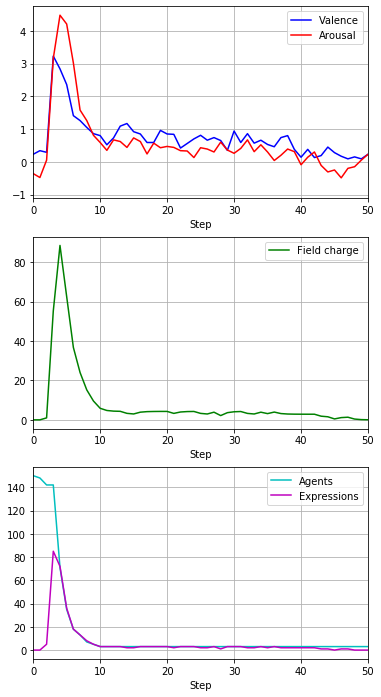

In [11]:
visualize(data)